In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset




In [ ]:
DEBUG = True # Used to display additional information during program execution
TEST_SIZE = 1000
VALIDATION_SIZE = 1000
EPOCHS = 10
LEARNING_RATE = 0.001

n = 785
m = 70000
labels_train.shape = (68000,)
values_train.shape = (784, 68000)
labels_test.shape = (1000,)
values_test.shape = (784, 1000)


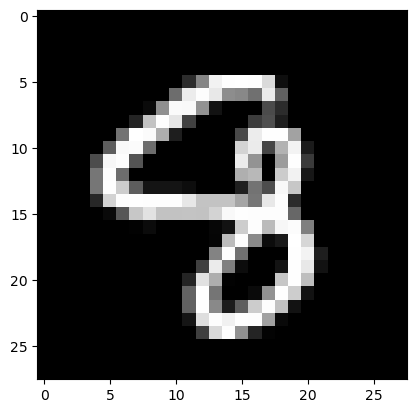

Label: 8


In [64]:
# Load dataset from a file
data = pd.read_csv('Datasets/MNIST_CSV/mnist.csv', header=None)
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

# Split data into test, validation, and training sets
data_test = data[0:TEST_SIZE].T
labels_test = data_test[0]
values_test = data_test[1:n].astype(np.float32) / 255.0 # converted and normalized

data_validation = data[TEST_SIZE:(TEST_SIZE+VALIDATION_SIZE)].T
labels_validation = data_validation[0]
values_validation = data_validation[1:n].astype(np.float32) / 255.0 # converted and normalized

data_train = data[(TEST_SIZE+VALIDATION_SIZE):m].T
labels_train = data_train[0]
values_train = data_train[1:n].astype(np.float32) / 255.0   # converted and normalized

def show_image(values, index):
    """
    Display image selected by index from given values matrix
    """
    image = values[:, index, None]
    image = image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(image)
    plt.show()

if DEBUG:
    print("n =", n)
    print("m =", m)
    print("labels_train.shape =", labels_train.shape)
    print("values_train.shape =", values_train.shape)
    print("labels_test.shape =", labels_test.shape)
    print("values_test.shape =", values_test.shape)
    show_image(values_train, 0)
    print("Label:", labels_train[0])


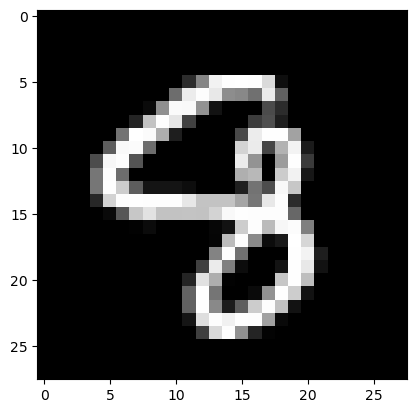

Sample Label: 8


In [65]:
# Convert to PyTorch tensors
values_train = torch.tensor(values_train.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_train = torch.tensor(labels_train, dtype=torch.long)
dataset_train = TensorDataset(values_train, labels_train)
loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)

values_validation = torch.tensor(values_validation.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_validation = torch.tensor(labels_validation, dtype=torch.long)
dataset_validation = TensorDataset(values_validation, labels_validation)
loader_validation = DataLoader(dataset_validation, batch_size=64, shuffle=False)

values_test = torch.tensor(values_test.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_test = torch.tensor(labels_test, dtype=torch.long)
dataset_test = TensorDataset(values_test, labels_test)
loader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)

# Option to print a sample to verify data correctness
if DEBUG:
    sample_idx = 0
    plt.imshow(values_train[sample_idx].squeeze(), cmap="gray")
    plt.show()
    print("Sample Label:", labels_train[sample_idx].item())

In [66]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x
    


Epoch [1/10], Step [1/1063], Loss: 2.2943
Epoch [1/10], Step [2/1063], Loss: 2.2974
Epoch [1/10], Step [3/1063], Loss: 2.3324
Epoch [1/10], Step [4/1063], Loss: 2.2707
Epoch [1/10], Step [5/1063], Loss: 2.2690
Epoch [1/10], Step [6/1063], Loss: 2.2011
Epoch [1/10], Step [7/1063], Loss: 2.1731
Epoch [1/10], Step [8/1063], Loss: 2.1772
Epoch [1/10], Step [9/1063], Loss: 2.1308
Epoch [1/10], Step [10/1063], Loss: 2.0981
Epoch [1/10], Step [11/1063], Loss: 2.0197
Epoch [1/10], Step [12/1063], Loss: 1.9580
Epoch [1/10], Step [13/1063], Loss: 1.9003
Epoch [1/10], Step [14/1063], Loss: 1.9152
Epoch [1/10], Step [15/1063], Loss: 1.8417
Epoch [1/10], Step [16/1063], Loss: 1.5644
Epoch [1/10], Step [17/1063], Loss: 1.5369
Epoch [1/10], Step [18/1063], Loss: 1.5215
Epoch [1/10], Step [19/1063], Loss: 1.4932
Epoch [1/10], Step [20/1063], Loss: 1.5254
Epoch [1/10], Step [21/1063], Loss: 1.4773
Epoch [1/10], Step [22/1063], Loss: 1.3254
Epoch [1/10], Step [23/1063], Loss: 1.0516
Epoch [1/10], Step [

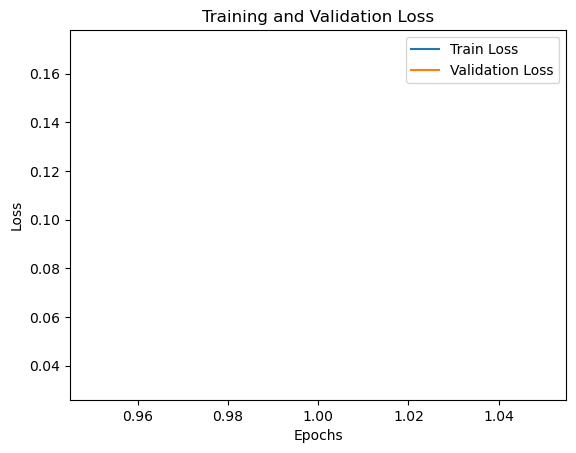

Epoch [2/10], Step [1/1063], Loss: 0.0269
Epoch [2/10], Step [2/1063], Loss: 0.0582
Epoch [2/10], Step [3/1063], Loss: 0.0239
Epoch [2/10], Step [4/1063], Loss: 0.0796
Epoch [2/10], Step [5/1063], Loss: 0.0567
Epoch [2/10], Step [6/1063], Loss: 0.0196
Epoch [2/10], Step [7/1063], Loss: 0.0298
Epoch [2/10], Step [8/1063], Loss: 0.1567
Epoch [2/10], Step [9/1063], Loss: 0.1141
Epoch [2/10], Step [10/1063], Loss: 0.0678
Epoch [2/10], Step [11/1063], Loss: 0.0076
Epoch [2/10], Step [12/1063], Loss: 0.0514
Epoch [2/10], Step [13/1063], Loss: 0.0240
Epoch [2/10], Step [14/1063], Loss: 0.0985
Epoch [2/10], Step [15/1063], Loss: 0.1274
Epoch [2/10], Step [16/1063], Loss: 0.1708
Epoch [2/10], Step [17/1063], Loss: 0.0273
Epoch [2/10], Step [18/1063], Loss: 0.0620
Epoch [2/10], Step [19/1063], Loss: 0.0132
Epoch [2/10], Step [20/1063], Loss: 0.0050
Epoch [2/10], Step [21/1063], Loss: 0.0599
Epoch [2/10], Step [22/1063], Loss: 0.0151
Epoch [2/10], Step [23/1063], Loss: 0.0345
Epoch [2/10], Step [

In [67]:
# Training setup

# Prefer CUDA > metal > CPU
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_train_history = []
loss_validation_history = []
start_time = time.time()

plt.ion()
fig, ax = plt.subplots()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(loader_train):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(loader_train)}], Loss: {loss.item():.4f}")
    
    loss_train_history.append(running_loss / len(loader_train))

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader_validation:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    loss_validation_history.append(val_loss / len(loader_validation))
    
    ax.clear()
    ax.plot(range(1, epoch+2), loss_train_history, label='Train Loss')
    ax.plot(range(1, epoch+2), loss_validation_history, label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title('Training and Validation Loss')
    plt.pause(0.1)

end_time = time.time()
training_time = end_time - start_time

plt.ioff()
plt.show()


In [69]:
# Plot training and validation loss
plt.plot(range(1, EPOCHS+1), loss_train_history, label='Train Loss')
plt.plot(range(1, EPOCHS+1), loss_validation_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate model
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

train_acc = evaluate(loader_train)
val_acc = evaluate(loader_validation)
test_acc = evaluate(loader_test)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")


NameError: name 'loss_train_history' is not defined